In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)

In [7]:
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_04860.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_02040.png')]

In [8]:
labels = get_image_files(path_lbl)
labels[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01830_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07830_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010200_P.png')]

In [0]:
get_label_filename = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

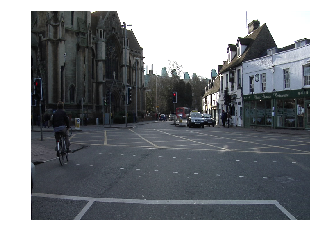

In [10]:
img = open_image(fnames[0])
img.show(figsize=(5, 5))

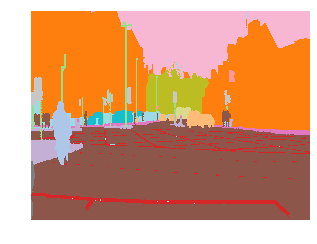

In [11]:
mask = open_mask(get_label_filename(fnames[0]))
mask.show(figsize=(5, 5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
print(codes)

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


In [0]:
src = (SegmentationItemList.from_folder(path_img)
                          .split_by_fname_file('../valid.txt')
                          .label_from_func(get_label_filename, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=src_size // 2, tfm_y=True)  # transform y as well, otherwise it won't match
           .databunch(bs=2)  # can't handle much because it's an expensive problem
           .normalize(imagenet_stats))

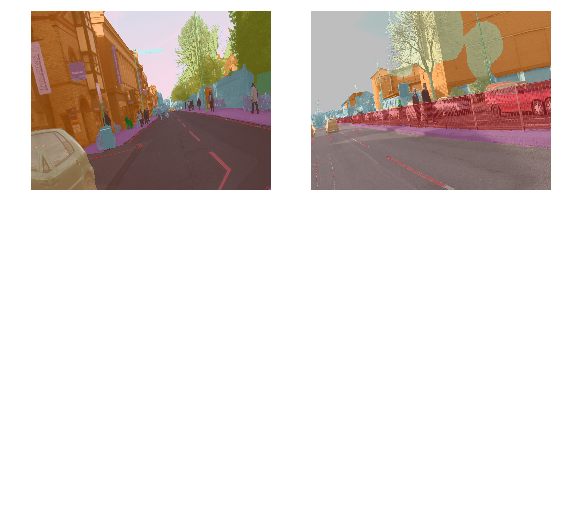

In [20]:
data.show_batch()

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def custom_acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
# An architecture called U-Net works better for segmentation
learn = unet_learner(data, models.resnet34, metrics=custom_acc)

In [19]:
lr_find(learn)

epoch,train_loss,valid_loss,custom_acc


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


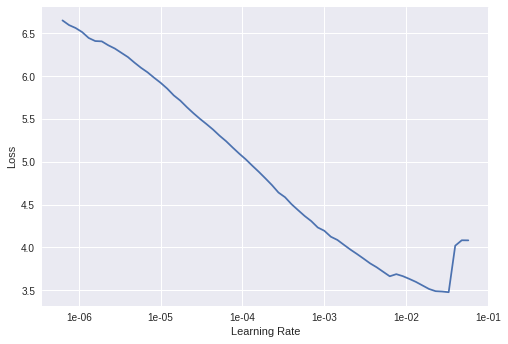

In [20]:
learn.recorder.plot()

In [0]:
lr = 1e-3

In [22]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,custom_acc
1,1.128518,0.861141,0.801668
2,0.779810,0.656687,0.835521
3,0.683282,0.617184,0.838352
4,0.631868,0.506880,0.871872
5,0.520260,0.404819,0.892037
6,0.458720,0.322000,0.913414
7,0.399689,0.323100,0.913545
8,0.356722,0.301518,0.914387
9,0.316166,0.295189,0.915947
10,0.307596,0.287484,0.918429


In [0]:
learn.save('stage-1')

In [24]:
!find /root -name 'stage-1.pth'

/root/.fastai/data/planet/models/stage-1.pth
/root/.fastai/data/camvid/images/models/stage-1.pth


In [0]:
!cp /root/.fastai/data/camvid/images/models/stage-1.pth gdrive/"My Drive"/fastai-v3/camvid-stage-1.pth

In [0]:
learn.unfreeze()

In [27]:
lr_find(learn)

epoch,train_loss,valid_loss,custom_acc


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


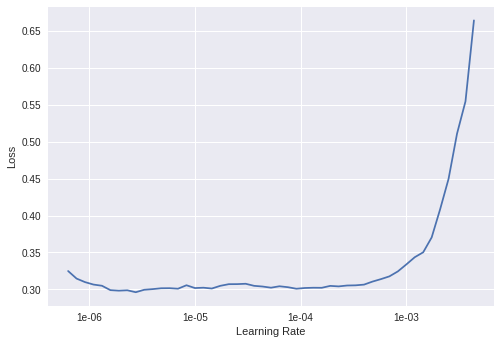

In [28]:
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, lr/5)

In [30]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,custom_acc
1,0.307107,0.285035,0.919241
2,0.313691,0.291592,0.917472
3,0.323536,0.271143,0.927449
4,0.304760,0.277401,0.919349
5,0.292919,0.299204,0.912025
6,0.274437,0.260988,0.925595
7,0.264379,0.280051,0.918307
8,0.238342,0.274676,0.921257
9,0.236213,0.269054,0.921806
10,0.233321,0.263200,0.923351


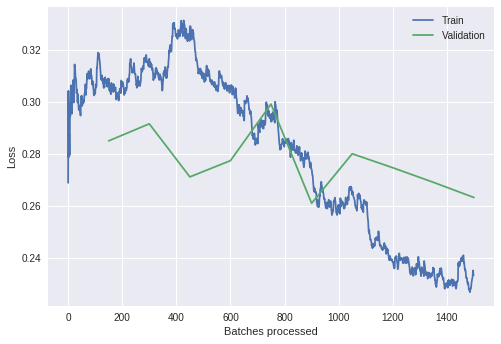

In [34]:
learn.recorder.plot_losses()

You'll notice that in the loss function curve, the loss almost always goes up before it goes down. Why is that? To understand this, we plot the learning rate over iterations.

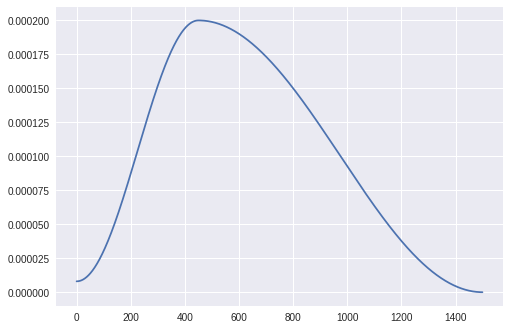

In [35]:
learn.recorder.plot_lr()

Because we used `fit_one_cycle`, the learning rate goes up and then down. Why is this a good thing? See [this visualization of gradient descent] to understand why picking the right learning rate is so important. Now as you get closer to the optimum, you want your learning rate to decrease. Because in general, the loss surface is not smooth, initially you want a higher learning rate to get out of local optima, but later, you want to slow down so that you don't simply keep jumping between "hills". 

The idea of decreasing your learning rate is called learning rate annealing, and has been around for quite some time. But the idea of increasing it first is recent, due to Leslie Smith. It turns out that gradually increasing the learning rate and then decreasing it is a good way of exploring the whole loss surface, but also finding areas of minima.

So if you find the loss going up a little before going down, you've found a good maximum learning rate.

In [0]:
learn.save('stage-2')

In [0]:
!cp /root/.fastai/data/camvid/images/models/stage-2.pth gdrive/"My Drive"/fastai-v3/camvid-stage-2.pth

This only segments half the pixels, because we used `size = src_size // 2`. Now we go big. Restart the kernel here to clear GPU memory.

In [0]:
data = (src.transform(get_transforms(), size=src_size, tfm_y=True)  # transform y as well, otherwise it won't match
           .databunch(bs=2)  # can't handle much because it's an expensive problem
           .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=custom_acc)

In [26]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /root/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [27]:
lr_find(learn)

epoch,train_loss,valid_loss,custom_acc


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


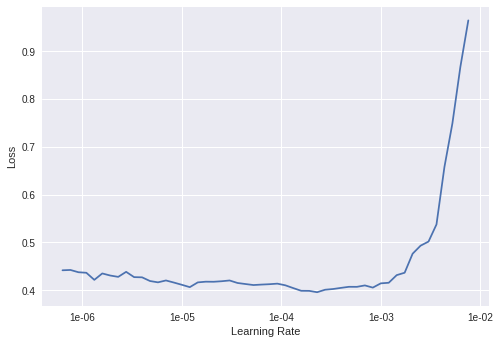

In [28]:
learn.recorder.plot()

In [0]:
lr = 1e-4

In [30]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,custom_acc
1,0.366436,0.329816,0.908033
2,0.332740,0.315571,0.912942
3,0.325398,0.289564,0.917960
4,0.315038,0.313255,0.911758
5,0.281566,0.325656,0.909832
6,0.268085,0.280211,0.922928
7,0.255159,0.284697,0.922135
8,0.238957,0.280829,0.922451
9,0.233040,0.275092,0.924857
10,0.240035,0.270919,0.925516


In [0]:
learn.save('stage-1-big')

In [0]:
learn.unfreeze()

In [0]:
lr = 1e-6

In [0]:
learn.fit_one_cycle(10, slice(lr))

In [0]:
learn.save('stage-2-big')

In [0]:
learn.show_results()

How good is this model? Compared to [The One Hundred Layers Tiramisu](https://arxiv.org/pdf/1611.09326.pdf), which was state-of-the-art (91.5%), we got a better accuracy!

If you run out of GPU memory frequently, you can use mixed-precision learning, which is using 16-bit floating points rather than 32-bit. Add `.to_fp16()` at the end of the `learner` line to do this in `fastai`. Because this is new, you'll need the latest CUDA drivers to work. With recent GPUs like 2080Ti, it'll also run twice as fast.